In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/SpeckledBand075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 17:44:22 - INFO - 197896726.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/SpeckledBand075/03/log.log', param_file='saved_models/kgc/SpeckledBand075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/SpeckledBand075/03/checkpoint/', model_path='saved_models/kgc/SpeckledBand075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='SpeckledBand', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, b

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2022-12-31 17:44:22 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2022-12-31 17:44:22 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 17:44:22 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 17:44:22 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 17:44:22 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 17:44:22 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2022-12-31 17:44:22 - INFO - data_helper.py - 441 - ==========
2022-12-31 17:44:22 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 17:44:22 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 17:44:22 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 17:44:22 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 17:44:22 - INFO - data_helper.py - 443 - ==========
2022-12-31 17:44:22 - INFO - data_helper.py - 445 - entity_spec

13670 16796


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

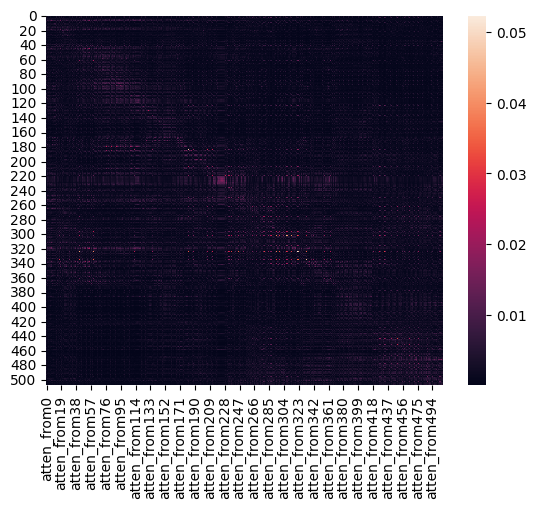

SpeckledBand:Roylott, ranking [2]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Watson,AllTitle:Watson,SpeckledBand:Julia_s_bedroom,AllTitle:Watson,SpeckledBand:Julia_s_bedroom
1,word.predicate:say,AllTitle:Holmes,AllTitle:Holmes,AllTitle:Watson,AllTitle:Holmes,AllTitle:Watson
2,bos_e,DancingMen:Elsie,SpeckledBand:Roylott,SilverBlaze:John_Straker,SpeckledBand:Julia_s_bedroom,SpeckledBand:bed
3,word.predicate:kill,DateTime:1883-04-01T15:00:00,AbbeyGrange:Stanley_Hopkins,SpeckledBand:Roylott_s_bedroom,CrookedMan:owner_of_lodge,SilverBlaze:John_Straker
4,word.predicate:sit,SpeckledBand:Julia_s_bedroom,word.predicate:see,DateTime:1883-04-01T15:00:00,SilverBlaze:John_Straker,SpeckledBand:Roylott_s_bedroom
5,word.predicate:have,DancingMen:Abe_Slaney,SpeckledBand:Julia_s_bedroom,SilverBlaze:Gregory_Inspector,DateTime:1883-04-01T15:00:00,SpeckledBand:Crown_Inn
6,word.predicate:meet,CrookedMan:Henry,DancingMen:Elsie,SpeckledBand:Crown_Inn,SpeckledBand:Helen,AllTitle:Holmes
7,word.predicate:happen,SpeckledBand:Roylott,DevilsFoot:Roundhay,SpeckledBand:bed,CrookedMan:Henry,SilverBlaze:Gregory_Inspector
8,word.predicate:go,DancingMen:Cubitt,DevilsFoot:Mortimer,SpeckledBand:VentilationHole,DateTime:1883-04-02T00:00:00,SpeckledBand:Roylott
9,word.predicate:come,AbbeyGrange:Stanley_Hopkins,SpeckledBand:Crown_Inn,DateTime:1883-04-02T00:00:00,SpeckledBand:VentilationHole,DateTime:1881-04-01T00:00:00


488

['SpeckledBand:299', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from488
495,SpeckledBand:300,kgc:hasPredicate,word.predicate:put,0.015764
502,mask_e,kgc:hasPredicate,word.predicate:kill,0.015368
477,SpeckledBand:297,kgc:hasPredicate,word.predicate:prepare,0.013766
301,SpeckledBand:268,kgc:hasPredicate,word.predicate:suspect,0.012931
489,SpeckledBand:299,kgc:hasPredicate,word.predicate:sit,0.012350
309,SpeckledBand:269,kgc:hasPredicate,word.predicate:exist,0.012228
443,SpeckledBand:292,kgc:hasPredicate,word.predicate:turnOff,0.011699
457,SpeckledBand:294,kgc:hasPredicate,word.predicate:notice,0.011366
323,SpeckledBand:271,kgc:hasPredicate,word.predicate:suspect,0.011181
275,SpeckledBand:264,kgc:hasPredicate,word.predicate:send,0.011169


----------


489

['SpeckledBand:299', 'kgc:hasPredicate', 'word.predicate:sit']

,head,relation,tail,atten_from489
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.008683
498,SpeckledBand:300,kgc:when,SpeckledBand:1883-04-02T01,0.008040
491,SpeckledBand:299,kgc:when,SpeckledBand:1883-04-02T00,0.007680
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.007274
473,SpeckledBand:296,kgc:when,SpeckledBand:1883-04-02T00,0.007181
471,SpeckledBand:296,kgc:subject,AllTitle:Watson,0.007147
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.007047
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.006902
485,SpeckledBand:298,kgc:when,SpeckledBand:1883-04-02T00,0.006837
488,SpeckledBand:299,kgc:subject,AllTitle:Watson,0.006721


----------


490

['SpeckledBand:299', 'kgc:where', 'SpeckledBand:chair']

,head,relation,tail,atten_from490
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.010312
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.010023
393,SpeckledBand:284,kgc:subject,SpeckledBand:bed,0.009731
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.008358
471,SpeckledBand:296,kgc:subject,AllTitle:Watson,0.007745
465,SpeckledBand:295,kgc:subject,AllTitle:Watson,0.007429
491,SpeckledBand:299,kgc:when,SpeckledBand:1883-04-02T00,0.007121
488,SpeckledBand:299,kgc:subject,AllTitle:Watson,0.007073
505,mask_e,kgc:why,mask_e,0.007002
482,SpeckledBand:298,kgc:subject,AllTitle:Holmes,0.006968


----------


491

['SpeckledBand:299', 'kgc:when', 'SpeckledBand:1883-04-02T00']

,head,relation,tail,atten_from491
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.008763
393,SpeckledBand:284,kgc:subject,SpeckledBand:bed,0.008688
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.008319
401,SpeckledBand:285,kgc:hasProperty,word.predicate:notFixed,0.007308
473,SpeckledBand:296,kgc:when,SpeckledBand:1883-04-02T00,0.007279
498,SpeckledBand:300,kgc:when,SpeckledBand:1883-04-02T01,0.006774
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.006435
468,SpeckledBand:295,kgc:when,SpeckledBand:1883-04-02T00,0.006315
398,SpeckledBand:284,kgc:time,DateTime:1881-12-02T00:00:00,0.005891
491,SpeckledBand:299,kgc:when,SpeckledBand:1883-04-02T00,0.005873


----------


492

['SpeckledBand:299', 'kgc:time', 'DateTime:1883-04-02T00:00:00']

,head,relation,tail,atten_from492
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.016756
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.015410
486,SpeckledBand:298,kgc:time,DateTime:1883-04-02T00:00:00,0.012538
469,SpeckledBand:295,kgc:time,DateTime:1883-04-02T00:00:00,0.010274
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.010266
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.010089
480,SpeckledBand:297,kgc:time,DateTime:1883-04-02T00:00:00,0.009853
491,SpeckledBand:299,kgc:when,SpeckledBand:1883-04-02T00,0.009727
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.009413
473,SpeckledBand:296,kgc:when,SpeckledBand:1883-04-02T00,0.009087


----------


493

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from493
40,SpeckledBand:227,kgc:hasPredicate,word.predicate:exist,0.008279
88,bos_e,bos_r,bos_e,0.006193
377,SpeckledBand:281,kgc:hasPredicate,word.predicate:exist,0.005879
94,bos_e,bos_r,bos_e,0.005840
217,bos_e,bos_r,bos_e,0.005723
112,bos_e,bos_r,bos_e,0.005672
76,bos_e,bos_r,bos_e,0.005651
82,bos_e,bos_r,bos_e,0.005636
162,SpeckledBand:248,kgc:hasPredicate,word.predicate:exist,0.005611
175,bos_e,bos_r,bos_e,0.005490


----------


494

['SpeckledBand:300', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from494
301,SpeckledBand:268,kgc:hasPredicate,word.predicate:suspect,0.012476
495,SpeckledBand:300,kgc:hasPredicate,word.predicate:put,0.011236
249,SpeckledBand:261,kgc:hasPredicate,word.predicate:say,0.009259
309,SpeckledBand:269,kgc:hasPredicate,word.predicate:exist,0.008988
323,SpeckledBand:271,kgc:hasPredicate,word.predicate:suspect,0.008740
502,mask_e,kgc:hasPredicate,word.predicate:kill,0.008208
457,SpeckledBand:294,kgc:hasPredicate,word.predicate:notice,0.008121
483,SpeckledBand:298,kgc:hasPredicate,word.predicate:sit,0.008104
275,SpeckledBand:264,kgc:hasPredicate,word.predicate:send,0.007843
477,SpeckledBand:297,kgc:hasPredicate,word.predicate:prepare,0.007492


----------


495

['SpeckledBand:300', 'kgc:hasPredicate', 'word.predicate:put']

,head,relation,tail,atten_from495
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.008011
458,SpeckledBand:294,kgc:what,AllTitle:Holmes,0.007492
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.007291
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.007058
324,SpeckledBand:271,kgc:what,SpeckledBand:VentilationHole,0.006919
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.006431
302,SpeckledBand:268,kgc:what,SpeckledBand:culprit,0.006388
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.006295
297,SpeckledBand:267,kgc:what,SpeckledBand:reason_of_sound,0.006044
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.005984


----------


496

['SpeckledBand:300', 'kgc:what', 'SpeckledBand:handgun']

,head,relation,tail,atten_from496
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.010268
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.008937
250,SpeckledBand:261,kgc:what,SpeckledBand:261a,0.008828
324,SpeckledBand:271,kgc:what,SpeckledBand:VentilationHole,0.008631
436,SpeckledBand:291,kgc:what,SpeckledBand:quiet,0.007981
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.007892
458,SpeckledBand:294,kgc:what,AllTitle:Holmes,0.007635
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.007627
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.007439
302,SpeckledBand:268,kgc:what,SpeckledBand:culprit,0.007290


----------


497

['SpeckledBand:300', 'kgc:on', 'SpeckledBand:desk']

,head,relation,tail,atten_from497
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.013850
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.010126
436,SpeckledBand:291,kgc:what,SpeckledBand:quiet,0.008639
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.007597
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.007552
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.007474
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.007181
497,SpeckledBand:300,kgc:on,SpeckledBand:desk,0.006753
302,SpeckledBand:268,kgc:what,SpeckledBand:culprit,0.006728
473,SpeckledBand:296,kgc:when,SpeckledBand:1883-04-02T00,0.006705


----------


498

['SpeckledBand:300', 'kgc:when', 'SpeckledBand:1883-04-02T01']

,head,relation,tail,atten_from498
398,SpeckledBand:284,kgc:time,DateTime:1881-12-02T00:00:00,0.009448
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.008200
214,SpeckledBand:257,kgc:what,SpeckledBand:plan,0.007595
236,SpeckledBand:259,kgc:where,SpeckledBand:Julia_s_bedroom,0.007402
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.007278
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.006989
239,SpeckledBand:259,kgc:when,SpeckledBand:1883-04-01T23:00,0.006837
302,SpeckledBand:268,kgc:what,SpeckledBand:culprit,0.006322
436,SpeckledBand:291,kgc:what,SpeckledBand:quiet,0.006160
238,SpeckledBand:259,kgc:when,SpeckledBand:tonight,0.006132


----------


499

['SpeckledBand:300', 'kgc:time', 'DateTime:1883-04-02T01:00:00']

,head,relation,tail,atten_from499
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.014047
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.013000
496,SpeckledBand:300,kgc:what,SpeckledBand:handgun,0.010783
486,SpeckledBand:298,kgc:time,DateTime:1883-04-02T00:00:00,0.010724
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.010659
469,SpeckledBand:295,kgc:time,DateTime:1883-04-02T00:00:00,0.010055
480,SpeckledBand:297,kgc:time,DateTime:1883-04-02T00:00:00,0.009147
436,SpeckledBand:291,kgc:what,SpeckledBand:quiet,0.009116
499,SpeckledBand:300,kgc:time,DateTime:1883-04-02T01:00:00,0.009057
444,SpeckledBand:292,kgc:what,SpeckledBand:lamp,0.008181


----------


500

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from500
40,SpeckledBand:227,kgc:hasPredicate,word.predicate:exist,0.008239
88,bos_e,bos_r,bos_e,0.006154
94,bos_e,bos_r,bos_e,0.005806
377,SpeckledBand:281,kgc:hasPredicate,word.predicate:exist,0.005799
162,SpeckledBand:248,kgc:hasPredicate,word.predicate:exist,0.005718
217,bos_e,bos_r,bos_e,0.005686
112,bos_e,bos_r,bos_e,0.005631
76,bos_e,bos_r,bos_e,0.005598
82,bos_e,bos_r,bos_e,0.005590
175,bos_e,bos_r,bos_e,0.005431


----------


501

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from501
301,SpeckledBand:268,kgc:hasPredicate,word.predicate:suspect,0.021671
323,SpeckledBand:271,kgc:hasPredicate,word.predicate:suspect,0.021138
249,SpeckledBand:261,kgc:hasPredicate,word.predicate:say,0.018118
296,SpeckledBand:267,kgc:hasPredicate,word.predicate:examine,0.017411
315,SpeckledBand:270,kgc:hasPredicate,word.predicate:see,0.014425
219,SpeckledBand:258,kgc:hasPredicate,word.predicate:instruct,0.014336
495,SpeckledBand:300,kgc:hasPredicate,word.predicate:put,0.013936
275,SpeckledBand:264,kgc:hasPredicate,word.predicate:send,0.013840
309,SpeckledBand:269,kgc:hasPredicate,word.predicate:exist,0.013652
258,SpeckledBand:261a,kgc:hasPredicate,word.predicate:have,0.013558


----------


502

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from502
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.012308
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.010753
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.009998
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.008187
480,SpeckledBand:297,kgc:time,DateTime:1883-04-02T00:00:00,0.008179
458,SpeckledBand:294,kgc:what,AllTitle:Holmes,0.008165
499,SpeckledBand:300,kgc:time,DateTime:1883-04-02T01:00:00,0.007681
231,SpeckledBand:258,kgc:time,DateTime:1883-04-01T17:00:00,0.007572
454,SpeckledBand:293,kgc:time,DateTime:1883-04-02T00:00:00,0.007268
240,SpeckledBand:259,kgc:time,DateTime:1883-04-01T23:00:00,0.007219


----------


503

['mask_e', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from503
495,SpeckledBand:300,kgc:hasPredicate,word.predicate:put,0.013867
323,SpeckledBand:271,kgc:hasPredicate,word.predicate:suspect,0.013141
502,mask_e,kgc:hasPredicate,word.predicate:kill,0.012339
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.012336
301,SpeckledBand:268,kgc:hasPredicate,word.predicate:suspect,0.012251
249,SpeckledBand:261,kgc:hasPredicate,word.predicate:say,0.011145
275,SpeckledBand:264,kgc:hasPredicate,word.predicate:send,0.011009
296,SpeckledBand:267,kgc:hasPredicate,word.predicate:examine,0.010245
489,SpeckledBand:299,kgc:hasPredicate,word.predicate:sit,0.009515
457,SpeckledBand:294,kgc:hasPredicate,word.predicate:notice,0.009023


----------


504

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from504
323,SpeckledBand:271,kgc:hasPredicate,word.predicate:suspect,0.018904
301,SpeckledBand:268,kgc:hasPredicate,word.predicate:suspect,0.015928
296,SpeckledBand:267,kgc:hasPredicate,word.predicate:examine,0.013682
495,SpeckledBand:300,kgc:hasPredicate,word.predicate:put,0.013212
249,SpeckledBand:261,kgc:hasPredicate,word.predicate:say,0.012379
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.011948
502,mask_e,kgc:hasPredicate,word.predicate:kill,0.011811
309,SpeckledBand:269,kgc:hasPredicate,word.predicate:exist,0.011703
275,SpeckledBand:264,kgc:hasPredicate,word.predicate:send,0.011034
219,SpeckledBand:258,kgc:hasPredicate,word.predicate:instruct,0.009748


----------


505

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from505
35,SpeckledBand:226,kgc:hasProperty,word.predicate:repaired,0.008827
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.008823
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.006986
231,SpeckledBand:258,kgc:time,DateTime:1883-04-01T17:00:00,0.006854
228,SpeckledBand:258,kgc:what,SpeckledBand:267,0.006553
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.006498
145,SpeckledBand:245,kgc:what,SpeckledBand:milk,0.006298
169,SpeckledBand:249,kgc:what,SpeckledBand:cat,0.006081
226,SpeckledBand:258,kgc:what,SpeckledBand:265,0.005977
393,SpeckledBand:284,kgc:subject,SpeckledBand:bed,0.005841


----------


506

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from506
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.018120
35,SpeckledBand:226,kgc:hasProperty,word.predicate:repaired,0.011391
394,SpeckledBand:284,kgc:hasProperty,word.predicate:fixed,0.009690
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.009218
250,SpeckledBand:261,kgc:what,SpeckledBand:261a,0.008733
302,SpeckledBand:268,kgc:what,SpeckledBand:culprit,0.007714
478,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.007691
324,SpeckledBand:271,kgc:what,SpeckledBand:VentilationHole,0.007677
458,SpeckledBand:294,kgc:what,AllTitle:Holmes,0.006826
506,mask_e,kgc:what,mask_e,0.006609


----------


507

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from507
393,SpeckledBand:284,kgc:subject,SpeckledBand:bed,0.008638
231,SpeckledBand:258,kgc:time,DateTime:1883-04-01T17:00:00,0.007049
492,SpeckledBand:299,kgc:time,DateTime:1883-04-02T00:00:00,0.006809
472,SpeckledBand:296,kgc:hasProperty,word.predicate:danger,0.006730
474,SpeckledBand:296,kgc:time,DateTime:1883-04-02T00:00:00,0.006435
398,SpeckledBand:284,kgc:time,DateTime:1881-12-02T00:00:00,0.006369
276,SpeckledBand:264,kgc:what,SpeckledBand:signal,0.006138
240,SpeckledBand:259,kgc:time,DateTime:1883-04-01T23:00:00,0.005914
167,SpeckledBand:249,kgc:subject,SpeckledBand:leopard,0.005746
324,SpeckledBand:271,kgc:what,SpeckledBand:VentilationHole,0.005564


----------


In [15]:
title = 'SpeckledBand'
victim_name = 'Julia'
killer_name = 'Roylott'
last_index = 300
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)